# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Dates

In [2]:
import datetime
import calendar

# Plot Settings

In [3]:
# format style
plt.style.use('fivethirtyeight')
# lineweight
plt.rc('lines', linewidth=3)
# figure size
plt.rc('figure', figsize=(12, 7))
# title fontsize
plt.rc('axes', titlesize=33) 
# axes label fontsize
plt.rc('axes', labelsize=28)
# axes values fontsize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
# legend fontsize
plt.rc('legend', fontsize=18)

# Data

## Data Source

In [4]:
# data link prefix
url_pre = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
# data link suffix
url_suf = '.txt'

In [5]:
# list of dates for data files
date_files = ['180609', '180616', '180623', '180630']

# Challenges

## 1. Import data

In [6]:
for i, date_file in enumerate(date_files):
    if i == 0:
        df_mta = pd.read_csv(url_pre + date_file + url_suf)
    else:
        df_mta = pd.concat([df_mta, pd.read_csv(url_pre + date_file + url_suf)], 
                           axis=0, ignore_index=True)

In [7]:
df_mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,00:00:00,REGULAR,6641277,2251216
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,04:00:00,REGULAR,6641302,2251222
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,08:00:00,REGULAR,6641319,2251256
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,12:00:00,REGULAR,6641395,2251325
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,16:00:00,REGULAR,6641575,2251370


## 2. Add datetime column

In [8]:
# add datetime column
df_mta['DATETIME'] = pd.to_datetime(df_mta['DATE'].astype(str) + ' ' + df_mta['TIME'].astype(str))
df_mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,00:00:00,REGULAR,6641277,2251216,2018-06-02 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,04:00:00,REGULAR,6641302,2251222,2018-06-02 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,08:00:00,REGULAR,6641319,2251256,2018-06-02 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,12:00:00,REGULAR,6641395,2251325,2018-06-02 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,16:00:00,REGULAR,6641575,2251370,2018-06-02 16:00:00


## 3. Daily entries per turnstile
Entries are cumulative so difference must be taken to return net entries

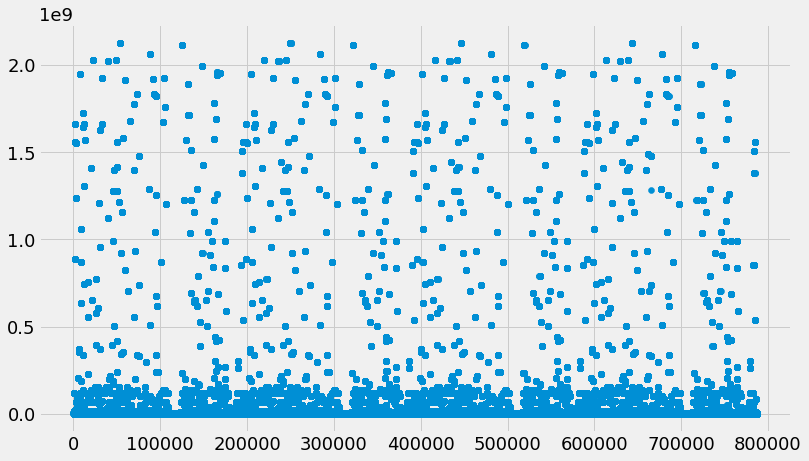

In [9]:
# plot entries
plt.scatter(range(len(df_mta['ENTRIES'])), df_mta['ENTRIES']);

In [10]:
# add turnstile id column
df_mta['ID'] = df_mta['UNIT'] + ' ' + df_mta['SCP'] # unit and SCP combined
df_mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ID
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,00:00:00,REGULAR,6641277,2251216,2018-06-02 00:00:00,R051 02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,04:00:00,REGULAR,6641302,2251222,2018-06-02 04:00:00,R051 02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,08:00:00,REGULAR,6641319,2251256,2018-06-02 08:00:00,R051 02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,12:00:00,REGULAR,6641395,2251325,2018-06-02 12:00:00,R051 02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,16:00:00,REGULAR,6641575,2251370,2018-06-02 16:00:00,R051 02-00-00


In [11]:
# define funtion to return net entries for given input
def net_entry(cum_entry):
    # subtract a date's first entry value from last entry value for net
    net = cum_entry.values[-1] - cum_entry.values[0]
    # remove instances of count resets
    if net < 0:
        return(np.nan)
    # remove instances of unrealisticly high values
    elif net > 100000:
        return(np.nan)
    else:
        return(net)

In [12]:
# apply function per turnstile per date
trnstl_daily = df_mta.groupby(['STATION', 'C/A', 'ID', 'DATE']).agg(net_entry)['ENTRIES'].reset_index()
trnstl_daily.head()

,STATION,C/A,ID,DATE,ENTRIES
0,1 AV,H007,R248 00-00-00,06/02/2018,2304.0
1,1 AV,H007,R248 00-00-00,06/03/2018,1969.0
2,1 AV,H007,R248 00-00-00,06/04/2018,3538.0
3,1 AV,H007,R248 00-00-00,06/05/2018,3232.0
4,1 AV,H007,R248 00-00-00,06/06/2018,3719.0


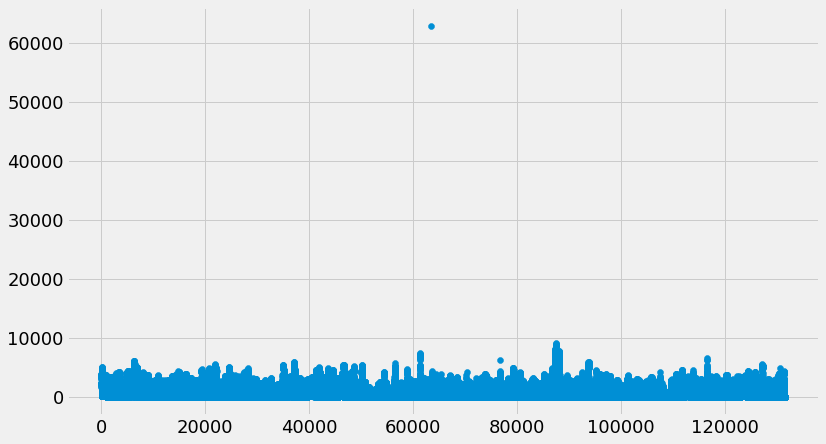

In [13]:
# visualize data for erratic points
plt.scatter(range(len(trnstl_daily)), trnstl_daily['ENTRIES']);

## 4. Turnstile daily time series

In [14]:
# select example turnstile for plot
turnstile = trnstl_daily['ID'][0]
# dates for example turnstile
dates = trnstl_daily[trnstl_daily['ID'] == turnstile]['DATE']
# entries for example turnstile
entries = trnstl_daily[trnstl_daily['ID'] == turnstile]['ENTRIES']

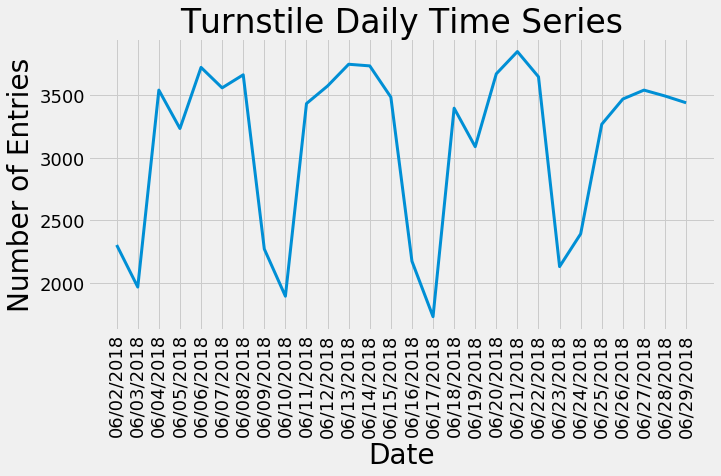

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(dates, entries)
plt.xticks(rotation='vertical')
plt.title('Turnstile Daily Time Series')
plt.xlabel('Date', )
plt.ylabel('Number of Entries');

## 5. Daily entries per Control Area

In [16]:
# sum entries for all turnstiles in each control area
ca_daily = trnstl_daily.groupby(['STATION', 'C/A', 'DATE']).sum().reset_index()
ca_daily.head()

,STATION,C/A,DATE,ENTRIES
0,1 AV,H007,06/02/2018,7547.0
1,1 AV,H007,06/03/2018,6376.0
2,1 AV,H007,06/04/2018,11195.0
3,1 AV,H007,06/05/2018,10167.0
4,1 AV,H007,06/06/2018,11845.0


## 6. Daily entries per Station

In [17]:
# sum entries for all control areas for each station
sta_daily = ca_daily.groupby(['STATION', 'DATE']).sum().reset_index()
sta_daily.head()

,STATION,DATE,ENTRIES
0,1 AV,06/02/2018,15077.0
1,1 AV,06/03/2018,12128.0
2,1 AV,06/04/2018,18640.0
3,1 AV,06/05/2018,16977.0
4,1 AV,06/06/2018,19654.0


## 7. Station daily time series

In [18]:
# select example turnstile for plot
station = sta_daily['STATION'][0]
# dates for example turnstile
dates = sta_daily[sta_daily['STATION'] == station]['DATE']
# entries for example turnstile
entries = sta_daily[sta_daily['STATION'] == station]['ENTRIES']

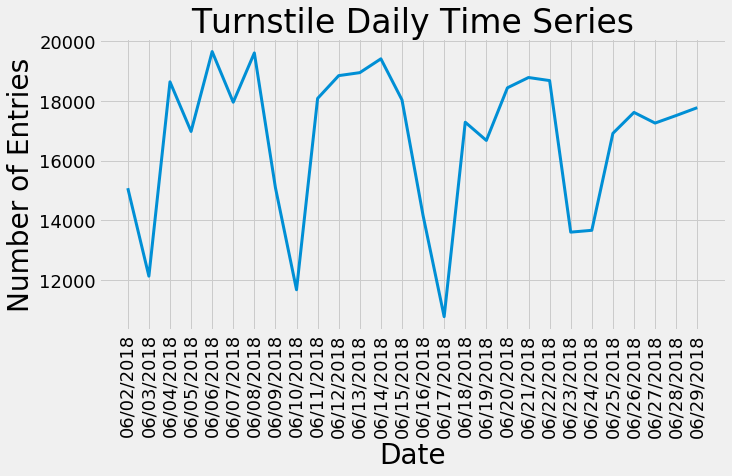

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(dates, entries)
plt.xticks(rotation='vertical')
plt.title('Turnstile Daily Time Series')
plt.xlabel('Date')
plt.ylabel('Number of Entries');

## 8. Station entries by day of week

In [20]:
# add weekday names to dataframe
sta_daily['WEEKDAY'] = sta_daily[sta_daily['STATION'] == station]['DATE'].apply(
    lambda x: calendar.day_name[datetime.datetime.strptime(x, '%m/%d/%Y').weekday()])
sta_daily.head()

,STATION,DATE,ENTRIES,WEEKDAY
0,1 AV,06/02/2018,15077.0,Saturday
1,1 AV,06/03/2018,12128.0,Sunday
2,1 AV,06/04/2018,18640.0,Monday
3,1 AV,06/05/2018,16977.0,Tuesday
4,1 AV,06/06/2018,19654.0,Wednesday


In [21]:
sta_weeks = sta_daily[sta_daily['STATION'] == station]
sta_weeks

,STATION,DATE,ENTRIES,WEEKDAY
0,1 AV,06/02/2018,15077.0,Saturday
1,1 AV,06/03/2018,12128.0,Sunday
2,1 AV,06/04/2018,18640.0,Monday
3,1 AV,06/05/2018,16977.0,Tuesday
4,1 AV,06/06/2018,19654.0,Wednesday
5,1 AV,06/07/2018,17956.0,Thursday
6,1 AV,06/08/2018,19609.0,Friday
7,1 AV,06/09/2018,15092.0,Saturday
8,1 AV,06/10/2018,11672.0,Sunday
9,1 AV,06/11/2018,18084.0,Monday


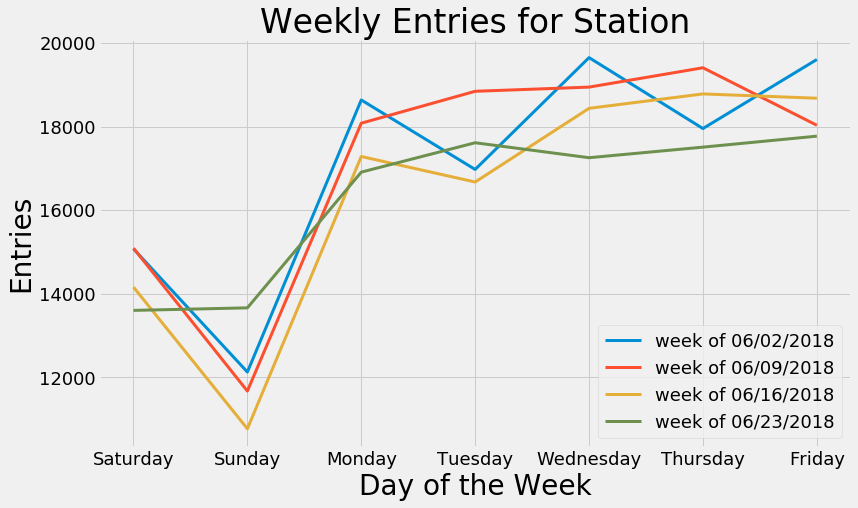

In [22]:
fig, ax = plt.subplots()

day = 0
for week in range(len(date_files)):
    ax.plot(sta_weeks['WEEKDAY'][day:day+7], sta_weeks['ENTRIES'][day:day+7], 
            label='week of ' + sta_weeks['DATE'][day])
    day += 7
    
ax.legend()
ax.set_title('Weekly Entries for Station')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Entries');

## 9. Total entries by station

In [23]:
# add all daily entries for period per station
sta_total = sta_daily.groupby('STATION').sum()
# sort by largest
sta_total.sort_values(by='ENTRIES', ascending=False, inplace=True)
sta_total.head()

,ENTRIES
STATION,
34 ST-PENN STA,3679338.0
GRD CNTRL-42 ST,3265752.0
34 ST-HERALD SQ,2357328.0
23 ST,2315555.0
14 ST-UNION SQ,2292109.0


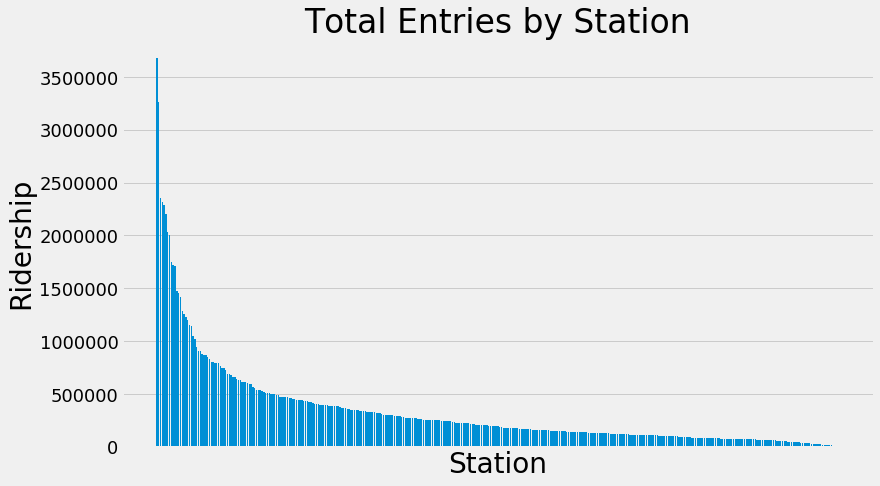

In [24]:
indices = range(len(sta_total))
plt.bar(indices, sta_total['ENTRIES'])
plt.xticks(indices, sta_total.index)
plt.xticks([])
plt.title('Total Entries by Station')
plt.xlabel('Station')
plt.ylabel('Ridership');

## 10. Total entry histogram

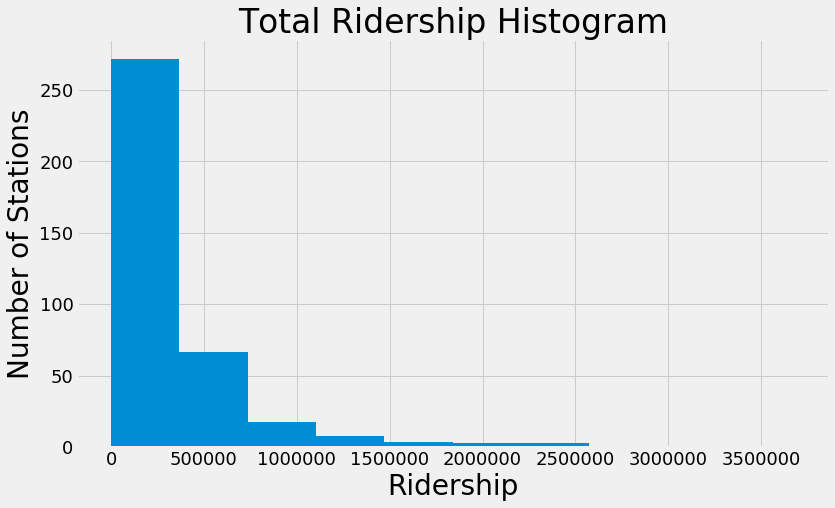

In [47]:
sta_total.hist()
plt.title('Total Ridership Histogram')
plt.xlabel('Ridership')
plt.ylabel('Number of Stations');

# Top Ridership Locations
Determine time and locations of highest volume of traffic

## Net volume per timestamp

In [26]:
df_mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ID
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,00:00:00,REGULAR,6641277,2251216,2018-06-02 00:00:00,R051 02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,04:00:00,REGULAR,6641302,2251222,2018-06-02 04:00:00,R051 02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,08:00:00,REGULAR,6641319,2251256,2018-06-02 08:00:00,R051 02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,12:00:00,REGULAR,6641395,2251325,2018-06-02 12:00:00,R051 02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2018,16:00:00,REGULAR,6641575,2251370,2018-06-02 16:00:00,R051 02-00-00


In [27]:
df_vol = df_mta.iloc[:, [3, 0, 12, 11, 9, 10, 8]].copy()
df_vol.head()

,STATION,C/A,ID,DATETIME,ENTRIES,EXITS,DESC
0,59 ST,A002,R051 02-00-00,2018-06-02 00:00:00,6641277,2251216,REGULAR
1,59 ST,A002,R051 02-00-00,2018-06-02 04:00:00,6641302,2251222,REGULAR
2,59 ST,A002,R051 02-00-00,2018-06-02 08:00:00,6641319,2251256,REGULAR
3,59 ST,A002,R051 02-00-00,2018-06-02 12:00:00,6641395,2251325,REGULAR
4,59 ST,A002,R051 02-00-00,2018-06-02 16:00:00,6641575,2251370,REGULAR


In [28]:
# reformat column names
df_vol.columns = df_vol.columns.str.lower().str.strip()

In [29]:
# calculate total volume per observation
df_vol['volume'] = df_vol['entries'] + df_vol['exits']

In [30]:
# calculate net volume per observation
df_vol['volume'] = df_vol['volume'].diff().shift(-1)

In [31]:
df_vol.head()

,station,c/a,id,datetime,entries,exits,desc,volume
0,59 ST,A002,R051 02-00-00,2018-06-02 00:00:00,6641277,2251216,REGULAR,31.0
1,59 ST,A002,R051 02-00-00,2018-06-02 04:00:00,6641302,2251222,REGULAR,51.0
2,59 ST,A002,R051 02-00-00,2018-06-02 08:00:00,6641319,2251256,REGULAR,145.0
3,59 ST,A002,R051 02-00-00,2018-06-02 12:00:00,6641395,2251325,REGULAR,225.0
4,59 ST,A002,R051 02-00-00,2018-06-02 16:00:00,6641575,2251370,REGULAR,263.0


In [32]:
# define function to remove unreasonable values
def net_vol(volume):
    # remove instances of count resets
    if volume < 0:
        return(np.nan)
    # remove instances of unrealisticly high values
    elif volume > 20000: # volume > 1 person per second
        return(np.nan)
    else:
        return(volume)

In [33]:
df_vol['volume'] = df_vol['volume'].apply(net_vol)

## Duplicates

In [52]:
# check for same id and datetime values
df_vol[df_vol.duplicated(['id', 'datetime'])]

,station,c/a,id,datetime,entries,exits,desc,volume


In [51]:
# remove duplicate observation rows
df_vol.drop_duplicates(['id', 'datetime'], inplace=True)

## Control Area
Sum ridership volume by control area

In [35]:
ca_vol = df_vol.groupby(['station', 'c/a', 'datetime'])['volume'].sum().reset_index()
ca_vol.head()

,station,c/a,datetime,volume
0,1 AV,H007,2018-06-02 00:00:00,1029.0
1,1 AV,H007,2018-06-02 04:00:00,858.0
2,1 AV,H007,2018-06-02 08:00:00,3284.0
3,1 AV,H007,2018-06-02 12:00:00,4854.0
4,1 AV,H007,2018-06-02 16:00:00,4638.0


## Volume per day of week
Sum ridership volume per control area by day of week

In [36]:
# add weekdays to dataframe
ca_vol['weekday'] = ca_vol['datetime'].apply(lambda x: x.weekday())
# add timestamps to dataframe
ca_vol['time'] = ca_vol['datetime'].apply(lambda x: x.time())
ca_vol.head()

,station,c/a,datetime,volume,weekday,time
0,1 AV,H007,2018-06-02 00:00:00,1029.0,5,00:00:00
1,1 AV,H007,2018-06-02 04:00:00,858.0,5,04:00:00
2,1 AV,H007,2018-06-02 08:00:00,3284.0,5,08:00:00
3,1 AV,H007,2018-06-02 12:00:00,4854.0,5,12:00:00
4,1 AV,H007,2018-06-02 16:00:00,4638.0,5,16:00:00


In [37]:
# calculate average volume per control area by weekday
ca_avg = ca_vol.groupby(['station', 'c/a', 'weekday', 'time']).mean().reset_index()
ca_avg.head()

,station,c/a,weekday,time,volume
0,1 AV,H007,0,00:00:00,295.25
1,1 AV,H007,0,04:00:00,2766.50
2,1 AV,H007,0,08:00:00,6091.75
3,1 AV,H007,0,12:00:00,3991.25
4,1 AV,H007,0,16:00:00,4659.25


In [38]:
# sort by volume in descending order
ca_avg.sort_values(by='volume', ascending=False).head(20)

,station,c/a,weekday,time,volume
28387,GRD CNTRL-42 ST,R238,3,16:00:00,35485.50
28381,GRD CNTRL-42 ST,R238,2,16:00:00,35324.75
28375,GRD CNTRL-42 ST,R238,1,16:00:00,35175.00
28393,GRD CNTRL-42 ST,R238,4,16:00:00,33339.75
28369,GRD CNTRL-42 ST,R238,0,16:00:00,33324.50
28385,GRD CNTRL-42 ST,R238,3,08:00:00,30911.50
28379,GRD CNTRL-42 ST,R238,2,08:00:00,30803.25
28373,GRD CNTRL-42 ST,R238,1,08:00:00,30351.25
28367,GRD CNTRL-42 ST,R238,0,08:00:00,30139.25
28391,GRD CNTRL-42 ST,R238,4,08:00:00,27427.75


## Top Station and Control Area

In [55]:
top_loc = ca_avg[(ca_avg['station'] == 'GRD CNTRL-42 ST') & (ca_avg['c/a'] == 'R238')]

In [56]:
# create table for heatmap
top_table = pd.pivot_table(top_loc, values='volume', index='time', columns='weekday')
# reorder weekday names
top_table.columns = [calendar.day_name[i] for i in range(7)]

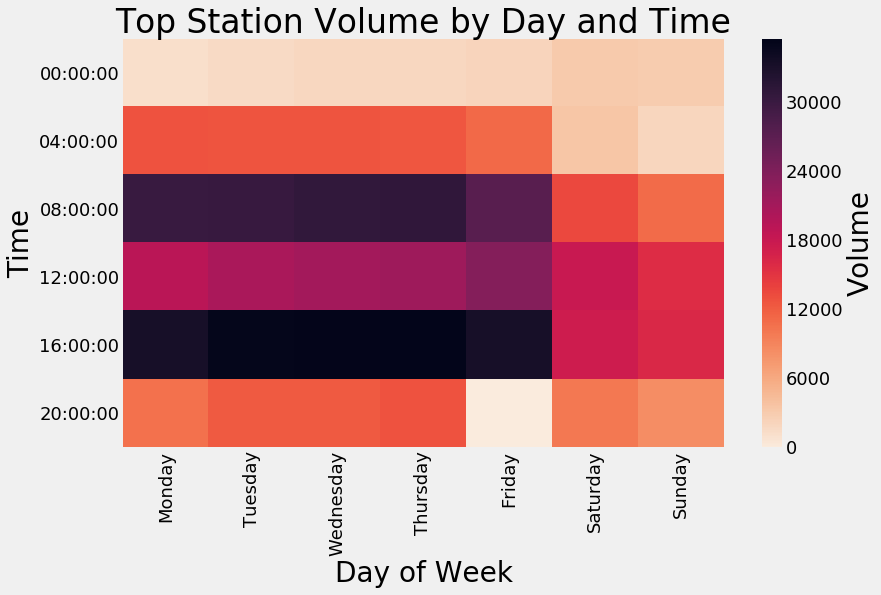

In [57]:
sns_ax = sns.heatmap(top_table, cmap=sns.cm.rocket_r, cbar_kws={'label': 'Volume'})
sns_ax.set(title='Top Station Volume by Day and Time', xlabel='Day of Week', ylabel='Time');